<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Exercise_8_Transfer_Learning_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer learning**

In [2]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [3]:
!pip3 install torch torchvision

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

**Loading data**

In [0]:
batch_size = 256
img_size = 64
norm = .5, .5, .5

to_cuda = tv.transforms.Lambda(lambda x: x.cuda())
y_to_cuda = tv.transforms.Lambda(lambda x: t.tensor(x, dtype = t.float32, device = 'cuda:0'))

transforms_train = tv.transforms.Compose([
  tv.transforms.RandomResizedCrop(size = 270),
  tv.transforms.RandomHorizontalFlip(),
  tv.transforms.RandomRotation(30),
  tv.transforms.ColorJitter(.1, .1, .1, .1),
  tv.transforms.Resize(img_size),
  tv.transforms.CenterCrop(img_size),
  tv.transforms.ToTensor(),
  to_cuda,
  tv.transforms.Normalize(norm, norm)
])

transforms_test = tv.transforms.Compose([
  tv.transforms.Resize(img_size),
  tv.transforms.CenterCrop(img_size),
  tv.transforms.ToTensor(),
  to_cuda,
  tv.transforms.Normalize(norm, norm)
])

dataset_train = tv.datasets.ImageFolder('/content/ants_and_bees/train', transform = transforms_train, target_transform = y_to_cuda)
dataset_test = tv.datasets.ImageFolder('/content/ants_and_bees/val', transform = transforms_test, target_transform = y_to_cuda)

loader_train = t.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
loader_test = t.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = False)

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

def plot_img(img):
  img = to_numpy(img)
  img = np.transpose(img, (1, 2, 0))
  img = img * norm + norm
  plt.imshow(img)

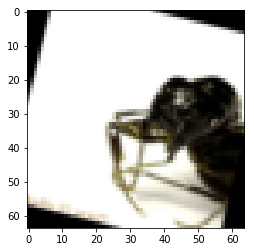

In [235]:
x, y = next(iter(loader_train))
plot_img(x[0])

**Define model**

In [0]:
model = tv.models.vgg19(pretrained = True)
model = model.cuda()
for param in model.parameters():
  param.requires_grad = False
model.classifier = t.nn.Sequential(
    t.nn.Flatten(),
    t.nn.Linear(in_features=512 * 2 * 2, out_features=512, bias=True),
    t.nn.ReLU(inplace=True),
    t.nn.Dropout(p=0.5, inplace=False),
    t.nn.Linear(in_features=512, out_features=128, bias=True),
    t.nn.ReLU(inplace=True),
    t.nn.Dropout(p=0.2, inplace=False),
    t.nn.Linear(in_features=128, out_features=1, bias=True)
  ).cuda()

**Training**

In [0]:
def accuracy(y_pred, y):
  return t.sum((y_pred > .5) == (y == 1)).item() / len(y)

In [238]:
epochs = 100
optimizer = t.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = t.nn.BCEWithLogitsLoss()
losses_train, losses_test, acc_train, acc_test = [], [], [], []

for epoch in range(epochs):
  # Train
  x, y = next(iter(loader_train))
  model.features.train()
  x2 = model.features.forward(x)
  model.classifier.train()
  y_pred = model.classifier.forward(x2)
  y_pred = y_pred.view(-1)
  loss = loss_fn(y_pred, y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  losses_train.append(loss)
  acc_train.append(accuracy(y_pred, y))
  # Test
  x, y = next(iter(loader_train))
  model.features.eval()
  x2 = model.features.forward(x)
  model.classifier.eval()
  y_pred = model.classifier.forward(x2)
  y_pred = y_pred.view(-1)
  loss = loss_fn(y_pred, y)
  losses_test.append(loss)
  acc_test.append(accuracy(y_pred, y))
  print('Epoch {} accuracy {}'.format(epoch + 1, acc_test[-1]))

Epoch 1 accuracy 0.5409836065573771
Epoch 2 accuracy 0.6926229508196722
Epoch 3 accuracy 0.7459016393442623
Epoch 4 accuracy 0.7622950819672131
Epoch 5 accuracy 0.7909836065573771
Epoch 6 accuracy 0.7622950819672131
Epoch 7 accuracy 0.7950819672131147
Epoch 8 accuracy 0.7868852459016393
Epoch 9 accuracy 0.7868852459016393
Epoch 10 accuracy 0.7581967213114754
Epoch 11 accuracy 0.7827868852459017
Epoch 12 accuracy 0.7745901639344263
Epoch 13 accuracy 0.8442622950819673
Epoch 14 accuracy 0.7868852459016393
Epoch 15 accuracy 0.8278688524590164
Epoch 16 accuracy 0.7745901639344263
Epoch 17 accuracy 0.8524590163934426
Epoch 18 accuracy 0.8565573770491803
Epoch 19 accuracy 0.7950819672131147
Epoch 20 accuracy 0.7991803278688525
Epoch 21 accuracy 0.8442622950819673
Epoch 22 accuracy 0.8483606557377049
Epoch 23 accuracy 0.8483606557377049
Epoch 24 accuracy 0.8319672131147541
Epoch 25 accuracy 0.7868852459016393
Epoch 26 accuracy 0.8237704918032787
Epoch 27 accuracy 0.8442622950819673
Epoch 28 a

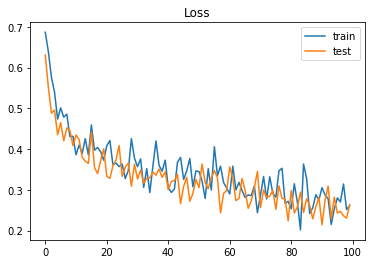

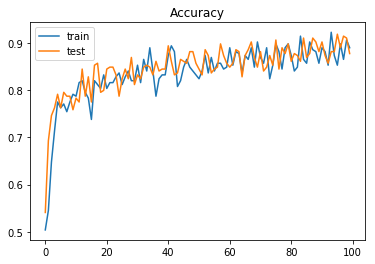

In [240]:
plt.plot(range(len(losses_train)), losses_train, label = 'train')
plt.plot(range(len(losses_test)), losses_test, label = 'test')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(range(len(acc_train)), acc_train, label = 'train')
plt.plot(range(len(acc_test)), acc_test, label = 'test')
plt.legend()
plt.title('Accuracy')
plt.show()